## Saving and Loading Models
In this notebook, I'll show you how to save and load models with PyTorch. This is important because you'll often want to load previously trained models to use in making predictions or to continue training on new data.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True)

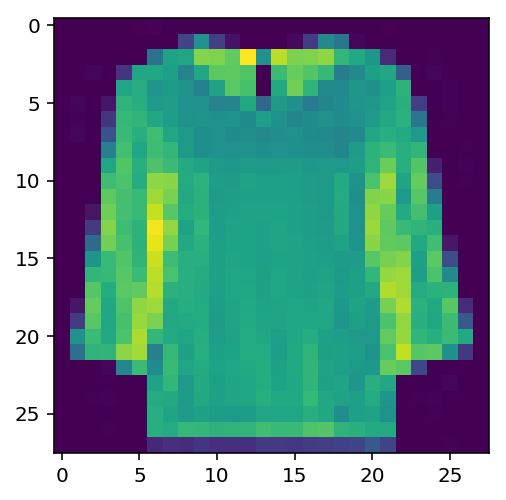

In [4]:
image, label = next(iter(trainloader))
plt.imshow(image[0].numpy().squeeze());

## Train a network

In [5]:
# training functions
def train(model, criterion, optimizer,tr_loader, val_loader, epochs):
    
    train_losses, test_losses = [], []
    for e in range(epochs):
        running_train_loss = 0
        for images, labels in tr_loader:
            model.train() # turn on dropout with some defined probability
            optimizer.zero_grad()
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_loss = running_train_loss/len(tr_loader)
        train_losses.append(train_loss)

        test_loss = 0
        with torch.no_grad(): # keep the context manager here, so it doesn't get called each time 
            model.eval()
            for images, labels in val_loader:
                 # turn off dropout with probability of 0
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                test_loss += loss.item()
                test_losses.append(loss.item())

                top_ps, top_cls = torch.exp(log_ps).topk(1, dim=1)
                accuracy = np.mean(top_cls.numpy().squeeze() == labels.numpy())

        print(f'Epoch: {e}\
        Train_Loss: {train_loss:.2f}\
        Test_Loss: {test_loss:.2f}\
        Test_Accuracy {accuracy*100:.2f}')    
    return train_losses, test_losses

def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.legend(frameon=False)

In [30]:
# define architecture
class DenseNetwork(nn.Module):
    def __init__(self, n_in, n_out, n_hs):
        super().__init__()
        self.fc1 = nn.Linear(n_in, n_hs[0])
        self.fc2 = nn.Linear(n_hs[0], n_hs[1])
        self.fc3 = nn.Linear(n_hs[1], n_hs[2])
        self.fc4 = nn.Linear(n_hs[2], n_out)

        # dropout with probability of 20%
        self.dropout = nn.Dropout(p=0.2) 
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x))) # add the dropout to the outputs units of a layer
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        return F.log_softmax(self.fc4(x), dim=1)

Epoch: 0        Train_Loss: 0.56        Test_Loss: 0.45        Test_Accuracy 84.14
Epoch: 1        Train_Loss: 0.42        Test_Loss: 0.40        Test_Accuracy 85.18
Epoch: 2        Train_Loss: 0.38        Test_Loss: 0.38        Test_Accuracy 86.37
Epoch: 3        Train_Loss: 0.36        Test_Loss: 0.39        Test_Accuracy 85.48
Epoch: 4        Train_Loss: 0.34        Test_Loss: 0.41        Test_Accuracy 84.98
Epoch: 5        Train_Loss: 0.33        Test_Loss: 0.37        Test_Accuracy 87.00
Epoch: 6        Train_Loss: 0.31        Test_Loss: 0.37        Test_Accuracy 87.19
Epoch: 7        Train_Loss: 0.31        Test_Loss: 0.34        Test_Accuracy 87.82
Epoch: 8        Train_Loss: 0.30        Test_Loss: 0.34        Test_Accuracy 88.05
Epoch: 9        Train_Loss: 0.29        Test_Loss: 0.36        Test_Accuracy 87.19
Epoch: 10        Train_Loss: 0.28        Test_Loss: 0.34        Test_Accuracy 88.56
Epoch: 11        Train_Loss: 0.28        Test_Loss: 0.34        Test_Accuracy 88.30
Ep

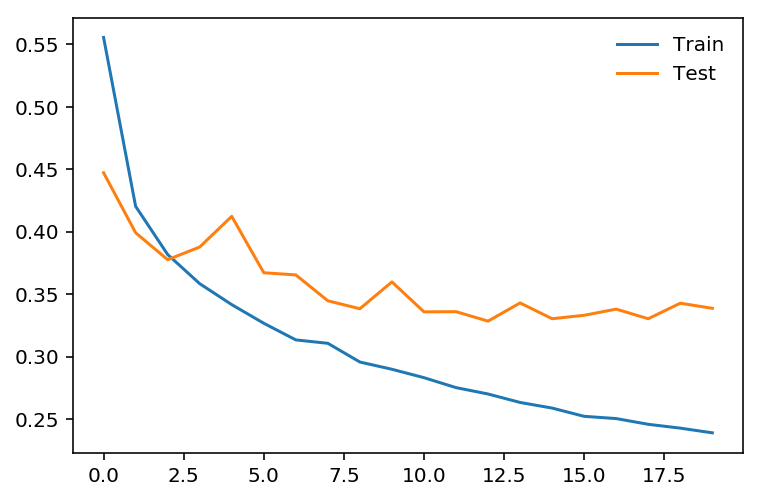

In [31]:
# Create the network, define the criterion and optimizer
model = DenseNetwork(784, 10, (512, 256, 128))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# model training
train_losses, test_losses = train(model, criterion, optimizer, trainloader, testloader, 20)

# plot the losses 
plot_losses(train_losses, test_losses)

## Saving and loading networks
As you can imagine, it's impractical to train a network every time you need to use it. Instead, we can save trained networks then load them later to train more or use them for predictions.

The parameters for PyTorch networks are stored in a model's state_dict. We can see the state dict contains the weight and bias matrices for each of our layers.

In [32]:
print("Our model: \n\n", model, '\n')
# the weights and biases of each layer are stored in the state dict
print("The state dict keys: \n\n", model.state_dict().keys()) 

Our model: 

 DenseNetwork(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


The simplest thing to do is simply save the state dict with torch.save. For example, we can save it to a file 'checkpoint.pth'.
(.pth is the standard pytorch model state save extension) 

In [33]:
from datetime import datetime

In [35]:
ts = datetime.now().strftime('%d-%b-%Y')
model_path = None
torch.save(model.state_dict(), f'{model.__class__.__name__}_{ts}.pth')

Then we can load the state dict with torch.load.

In [36]:
state_dict = torch.load(f'{model.__class__.__name__}_{ts}.pth')
state_dict.keys()

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])

In [39]:
model.load_state_dict(state_dict)
model

DenseNetwork(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

Seems pretty straightforward, but as usual it's a bit more complicated. Loading the state dict works only if the model architecture is exactly the same as the checkpoint architecture. If I create a model with a different architecture, this fails.

In [40]:
# Try this
model = DenseNetwork(784, 10, [400, 200, 100])
# This will throw an error because the tensor sizes are wrong!
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for DenseNetwork:
	size mismatch for fc1.weight: copying a param with shape torch.Size([512, 784]) from checkpoint, the shape in current model is torch.Size([400, 784]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([200, 400]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for fc3.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([100, 200]).
	size mismatch for fc3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for fc4.weight: copying a param with shape torch.Size([10, 128]) from checkpoint, the shape in current model is torch.Size([10, 100]).

This means we need to rebuild the model exactly as it was when trained. Information about the model architecture needs to be saved in the checkpoint, along with the state dict. To do this, you build a dictionary with all the information you need to compeletely rebuild the model, i.e., store the network hyperparms in a dict along with the state dict. 

In [46]:
def save_checkpoint(n_in, n_out, n_hs, model, time_stamp, save_path):
    model_meta = {
                    'in_size': n_in,
                    'out_size': n_out,
                    'hidden_layers': n_hs,
                    'state_dict': model.state_dict()
                 }
    torch.save(model_meta, f'{save_path}{model.__class__.__name__}_{time_stamp}.pth')
    return f'Model saved to {save_path}'

def load_checkpoint(filepath):
    model_meta = torch.load(filepath)
    model = DenseNetwork(model_meta['in_size'],
                         model_meta['out_size'],
                         model_meta['hidden_layers'])
    
    model.load_state_dict(model_meta['state_dict'])
    print('Model Loaded Successfully')
    return model

In [50]:
n_in, n_out, n_hs = (784, 10, (400, 200, 100))
save_checkpoint(n_in, n_out, n_hs, model, ts, '')

'Model saved to '

In [51]:
# laod Model
load_checkpoint(f'{model.__class__.__name__}_{ts}.pth')
print(model)

Model Loaded Successfully
DenseNetwork(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)
